# Content and Objective

- Illustrating several impulse responses with different sampling rates
- Show frequency and magnitude response

In [1]:
# importing
import numpy as np

from scipy import stats, special

import matplotlib.pyplot as plt
import matplotlib

# showing figures inline
%matplotlib inline


In [2]:

# plotting options 
font = {'size'   : 20}
plt.rc('font', **font)
plt.rc('text', usetex=False)

matplotlib.rc('figure', figsize=(14, 7) )

# Sampling with Symbol Rate: $t_s=T$

- Show some channel models out of Proakis: Digital Communications, MacGraw Hill, 2008

### Show some channel impulse responses

- Channels out of [Proakis]
- Called (a), (b), and (c) channel respectively

In [3]:
# impulse responses
h_a = np.array( [ .04, -.05, .07, -.21, -.5, .72, .36, 0, .21, .03, .07 ] )
h_b = np.array( [ .407, .815, .407 ] )
h_c = np.array( [ .227, .46, .688, .46, .227 ] )

In [4]:
# determine according frequency responses
N_fft = 512

H_a = np.fft.fft( np.hstack( ( h_a, np.zeros( N_fft - len(h_a) ) ) ) )
H_b = np.fft.fft( np.hstack( ( h_b, np.zeros( N_fft - len(h_b) ) ) ) )
H_c = np.fft.fft( np.hstack( ( h_c, np.zeros( N_fft - len(h_c) ) ) ) )

Omega = np.linspace( -np.pi, np.pi, N_fft )

Text(0.5, 0, '$\\Omega$')

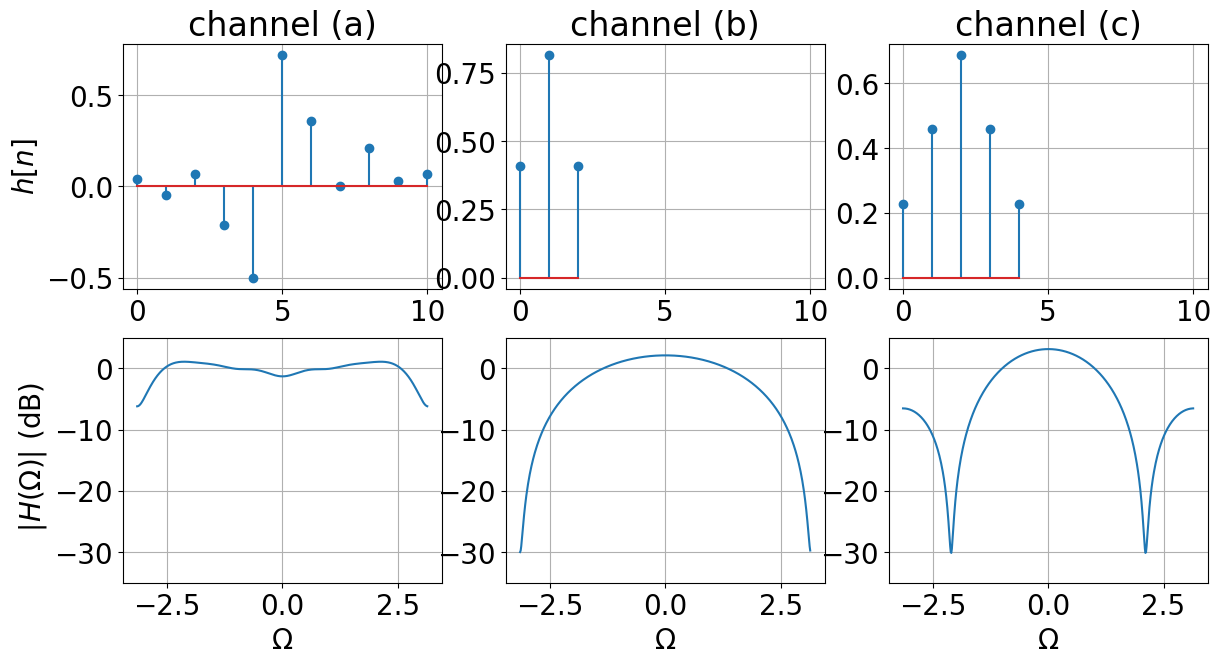

In [5]:
plt.figure()

plt.subplot(231)
plt.stem( h_a )
plt.title('channel (a)')
plt.ylabel('$h[n]$')
plt.xlabel('$n$')
plt.xlim( ( -.5, 10.5) )
plt.grid(1)

plt.subplot(232)
plt.stem( h_b )
plt.title('channel (b)')
plt.xlabel('$n$')
plt.xlim( ( -.5, 10.5) )
plt.grid(1)

plt.subplot(233)
plt.stem( h_c )
plt.title( 'channel (c)')
plt.xlabel('$n$')
plt.xlim( ( -.5, 10.5) )
plt.grid(1)

plt.subplot(234)
plt.plot( Omega, 10*np.log10( np.abs( np.fft.fftshift( H_a ) ) ) )
plt.ylabel( ' $|H(\\Omega)|$ (dB)' )
plt.ylim( (-35, 5))
plt.grid(1)
plt.xlabel('$\Omega$')

plt.subplot(235)
plt.plot( Omega, 10*np.log10( np.abs( np.fft.fftshift( H_b ) ) ) )
plt.ylim( (-35, 5))
plt.grid(1)
plt.xlabel('$\Omega$')

plt.subplot(236)
plt.plot( Omega, 10*np.log10( np.abs( np.fft.fftshift( H_c ) ) ))
plt.ylim( (-35, 5))
plt.grid(1)
plt.xlabel('$\Omega$')


### Filter symbol sequence with the according impulse response

- First choose channel to be used

In [6]:
# select channel
h = h_a

# length of impulse response
N_h = len( h )

In [7]:
# define length of symbol sequence
N_symb = 20

# generate BSPK sequence and filter
a = 1 - 2 * np.random.randint( 2, size=N_symb )

# filter with symbol-sampled impulse response
r = np.convolve( a, h )

# sliced regions, removing filter effects at the border
n_sliced = np.arange( N_h // 2, len( r ) - N_h // 2 ) 
r_sliced = r[ N_h // 2 : - N_h // 2 + 1 ]

**Exercise:** Reason the slicing applied in the last line of the previous cell.

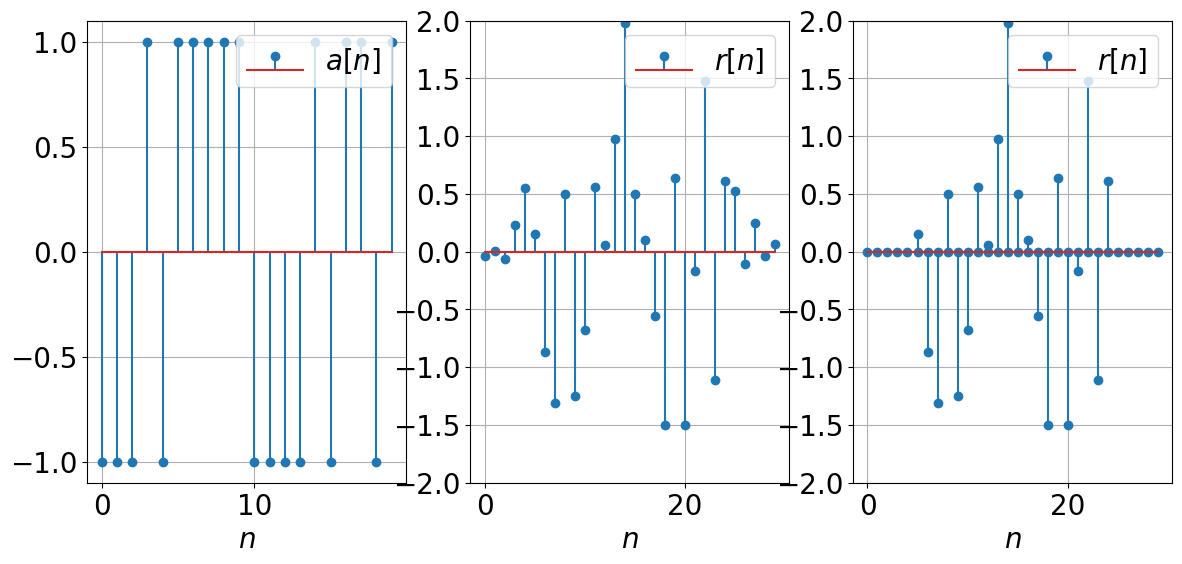

In [8]:
matplotlib.rc('figure', figsize=(14, 6) )

plt.figure()

plt.subplot(131)
plt.stem( a, label='$a[n]$' )
plt.grid(1)
plt.xlabel('$n$')
plt.legend(loc=1)

plt.subplot(132)
plt.stem( np.arange( 0, len(r) ), r, label='$r[n]$' )
plt.ylim( ( -2, 2) ) 
plt.grid(1)
plt.xlabel('$n$')
plt.legend(loc=1)

plt.subplot(133)
plt.stem( np.arange( 0, len(r) ), np.zeros_like(r) )
plt.stem( n_sliced, r_sliced, label='$r[n]$' )
plt.ylim( ( -2, 2 ) ) 
plt.grid(1)
plt.xlabel('$n$')
plt.legend(loc=1)

# Sampling with $n_{sps}$ Samples per Symbol: $t_s=T/n_{sps}$

- Illustrate that impulse shaping can be upsampled
- Apply on higher sample rate

In [9]:
# define symbol time
t_symb = 1.0

# # define number of samples per symbol
n_sps = 8

### Find impulse response of an RC filter


In [10]:
# find impulse response of an RC filter
def get_rc_ir(  K, n_sps, t_symbol, r):
    
    ''' 
    Determines coefficients of an RC filter 
    
    Formula out of: K.-D. Kammeyer, Nachrichtenübertragung
    At poles, l'Hospital was used 
    
    NOTE: Length of the IR has to be an odd number
    
    IN: length of IR, upsampling factor, symbol time, roll-off factor
    OUT: filter coefficients
    '''

    # check that IR length is odd
    assert K % 2 == 1, 'Length of the impulse response should be an odd number'
    
    # map zero r to close-to-zero
    if r == 0:
        r = 1e-32


    # initialize output length and sample time
    rc = np.zeros( K )
    t_sample = t_symbol / n_sps
    
    # time indices and sampled time
    k_steps = np.arange( -(K-1) / 2.0, (K-1) / 2.0 + 1 )   
    t_steps = k_steps * t_sample
    
    for k in k_steps.astype(int):
        
        if t_steps[k] == 0:
            rc[ k ] = 1. / t_symbol
            
        elif np.abs( t_steps[k] ) == t_symbol / ( 2.0 * r ):
            rc[ k ] = r / ( 2.0 * t_symbol ) * np.sin( np.pi / ( 2.0 * r ) )
            
        else:
            rc[ k ] = np.sin( np.pi * t_steps[k] / t_symbol ) / np.pi / t_steps[k] \
                * np.cos( r * np.pi * t_steps[k] / t_symbol ) \
                / ( 1.0 - ( 2.0 * r * t_steps[k] / t_symbol )**2 )
 
    return rc

In [11]:
# define raised cosine shape
N_rc = 65

# raised cosine parameter and get impulse response
beta_rc = 0.25

rc = get_rc_ir( N_rc, n_sps, t_symb, beta_rc )

N_fft = 512
RC = np.fft.fft( np.hstack( ( rc, np.zeros( N_fft - len( rc ) ) ) ) )
RC_dB_shifted = 10 * np.log10( np.abs( np.fft.fftshift ( RC ) ) )

Note: The pulse shape is a multiple of the symbol time and, thus, has length 65.


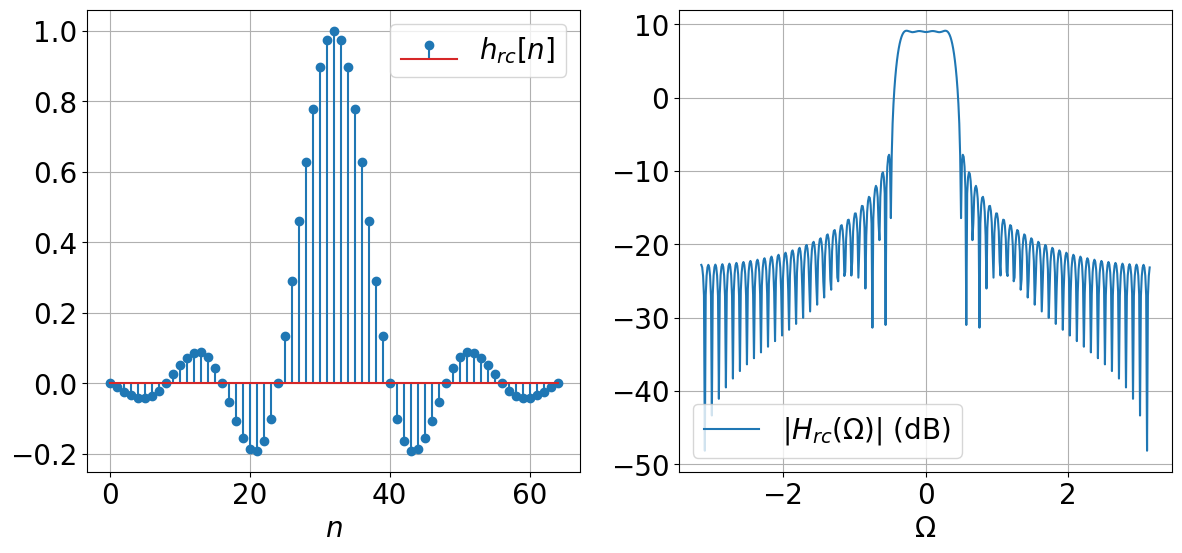

In [12]:
# activate if you want to see the impulse response and the magnitued (in dB) of the pulse-shaping filter
if 1:
    plt.figure()

    plt.subplot(121) 
    plt.stem( rc, label='$h_{rc}[n]$' )
    plt.grid(1)
    plt.xlabel('$n$')
    plt.legend(loc=1)

    plt.subplot(122) 
    plt.plot( np.linspace( -np.pi, np.pi, len( RC ) ), RC_dB_shifted, label = '$|H_{rc}(\\Omega)|$ (dB)' )
    plt.grid(1)
    plt.xlabel('$\\Omega$')
    plt.legend( loc=3 ) 

    print('Note: The pulse shape is a multiple of the symbol time and, thus, has length {}.'.format(N_rc) )

### Get symbols, modulate, and apply pulse-shaping

In [13]:
# number of symbols
N_symb = 100

# generate random binary vector and 
# modulate using BPSK
data = np.random.randint( 2, size = N_symb )
s = 1 - 2 * data

# use this "artifical" sequence to visualize effects on one single data
# s = np.hstack( ( 1, np.zeros( n_symb - 1 ) ) )

In [14]:

# apply RC filtering/pulse-shaping
s_up_rc = np.zeros( N_symb * n_sps )        
s_up_rc[ : : n_sps ] = s

s_rc = np.convolve( rc, s_up_rc)


# get spectrum using Bartlett method
N_fft = 512
Omega = np.linspace( -np.pi, np.pi, N_fft)

S_rc = np.fft.fftshift( np.fft.fft( s_rc, N_fft ) )

RC_PSD_sim = np.abs( S_rc )**2
RC_PSD_sim /= np.max( RC_PSD_sim )

### Show symbol sequence and pulse-shaped sequence

Text(0.5, 0, '$n$')

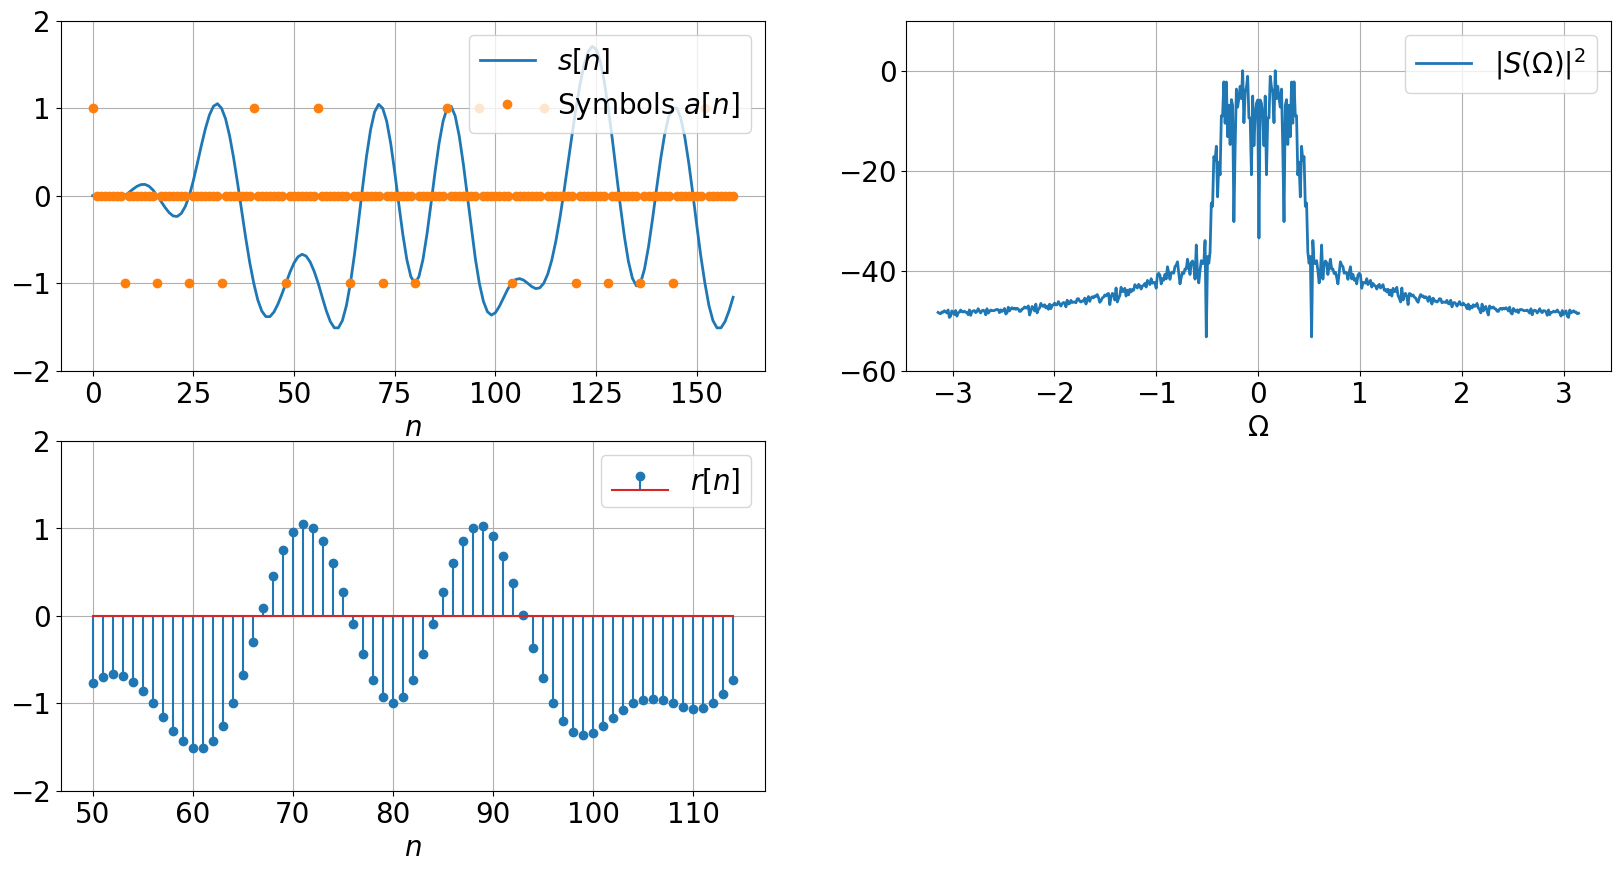

In [15]:
matplotlib.rc('figure', figsize=(20, 10) )

plt.figure()

plt.subplot(221)

# upper limit for number of symbols shown in the plot
ul = 20 * n_sps
plt.plot( np.arange( np.size( s_rc[ : ul ])) , s_rc[ : ul ], linewidth=2.0, label='$s[n]$' )
plt.plot( np.arange( np.size( s_up_rc[ : ul ])) , s_up_rc[ : ul ], 'o', linewidth=2.0, label='Symbols $a[n]$' )

plt.ylim( (-2, 2 ) )
plt.grid(True)    
plt.legend(loc='upper right')    
plt.xlabel('$n$')


plt.subplot(222)
np.seterr(divide='ignore') # ignore warning for logarithm of 0
plt.plot( Omega, 10*np.log10( RC_PSD_sim ), linewidth=2.0, label='$|S(\Omega)|^2$' )
np.seterr(divide='warn') # enable warning for logarithm of 0

plt.grid(True); 
plt.xlabel('$\\Omega$');  
plt.legend(loc='upper right')
plt.ylim( (-60, 10 ) )


plt.subplot(223)

# upper limit for number of samples shown in the plot
ll = 50
ul = ll + N_rc
plt.stem( np.arange( ll, ul ), s_rc[ ll: ul ], label='$r[n]$' )

plt.ylim( (-2, 2 ) )
plt.grid(True)    
plt.legend(loc='upper right')    
plt.xlabel('$n$')

### Now apply channel selected earlier to signal with higher sampling rate

+ First, Kaiser filter is defined that is later used for image suppression
+ Second, upsampling is performed by first adding zeros and then applying the Kaiser filter as an image filter

In [16]:
# define impulse reponse of the image filter

# import library
from scipy import signal 

# define Nyquist frequency after upsampling
f_Nyquist = n_sps / ( 2. * t_symb ) 

# apply "real-world" filtering
cutoff_freq = f_Nyquist / n_sps 

ripple_db = 60                      # ripples and transition width of the filter
width = f_Nyquist / 200.0

N_Kaiser, beta_Kaiser = signal.kaiserord( ripple_db, width)    # find filter order and beta parameter

# find filter and filter input
taps = signal.firwin( N_Kaiser, cutoff=cutoff_freq,  window=('kaiser', beta_Kaiser), nyq = f_Nyquist)

# impulse and frequency response of the filter
w_Kaiser, H_Kaiser = signal.freqz( taps )
h_Kaiser = taps


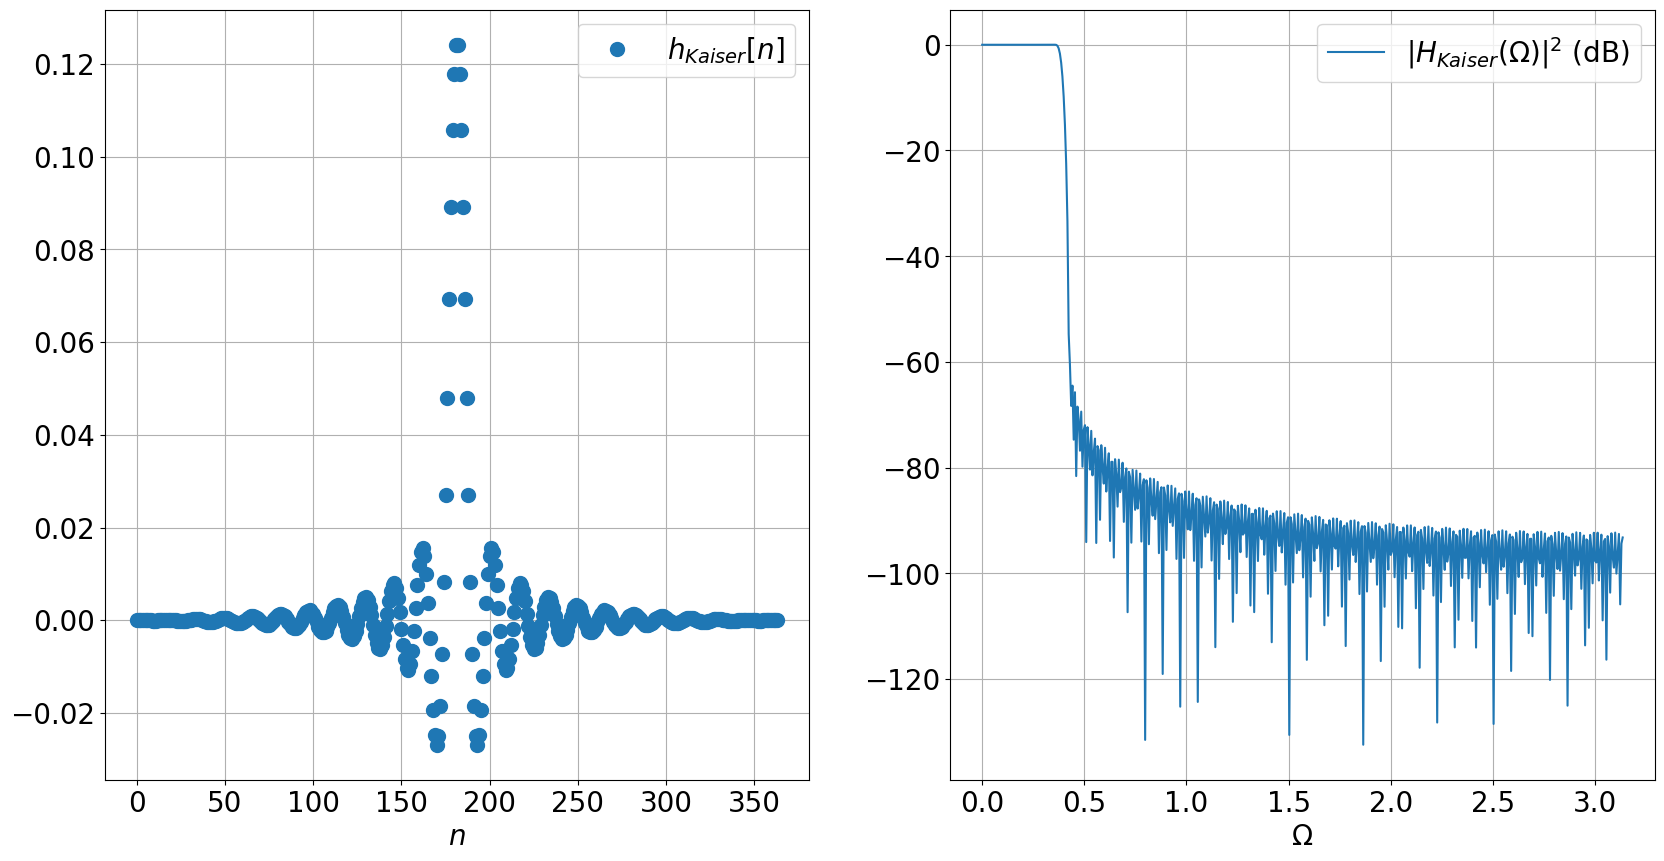

In [17]:
# activate if you want to see the impulse response and the magnitued (in dB) of the image filter
if 1:
    plt.figure(3)

    plt.subplot(121)
    plt.plot(np.arange(0, len(h_Kaiser)), h_Kaiser, 'o', markersize=10, label='$h_{Kaiser}[n]$')
    plt.grid(True)
    plt.xlabel('$n$')
    #plt.ylabel('$h[n]$')
    plt.legend(loc='upper right')      

    plt.subplot(122)        
    plt.plot(w_Kaiser, 10*np.log10(abs(H_Kaiser)**2), label='$|H_{Kaiser}(\\Omega)|^2$ (dB)')
    plt.grid(True)
    plt.xlabel('$\\Omega$')
    #plt.ylabel('$|H(f)|^2 (dB)$')
    plt.legend(loc='upper right')  


In [18]:
# generate channel impulse reponse with higher sample rate and then apply the channel selected earlier
h_up = np.zeros( len(h) * n_sps )
h_up[ : : n_sps ] = h

# apply previously defined image filter to get "clean" Nyquist band
h_up = np.convolve( h_up, h_Kaiser )

N_fft = 512

Omega = np.linspace( -np.pi, np.pi, N_fft)
H_up = np.fft.fft( np.hstack( ( h_up, np.zeros( N_fft - len( h_up ) ) ) ) )
H_up_dB_shifted = 10 * np.log10( np.abs( np.fft.fftshift( H_up ) )**2 ) 

### Plot upsampled channel impulse response and magnitude

Text(0.5, 0, '$n$')

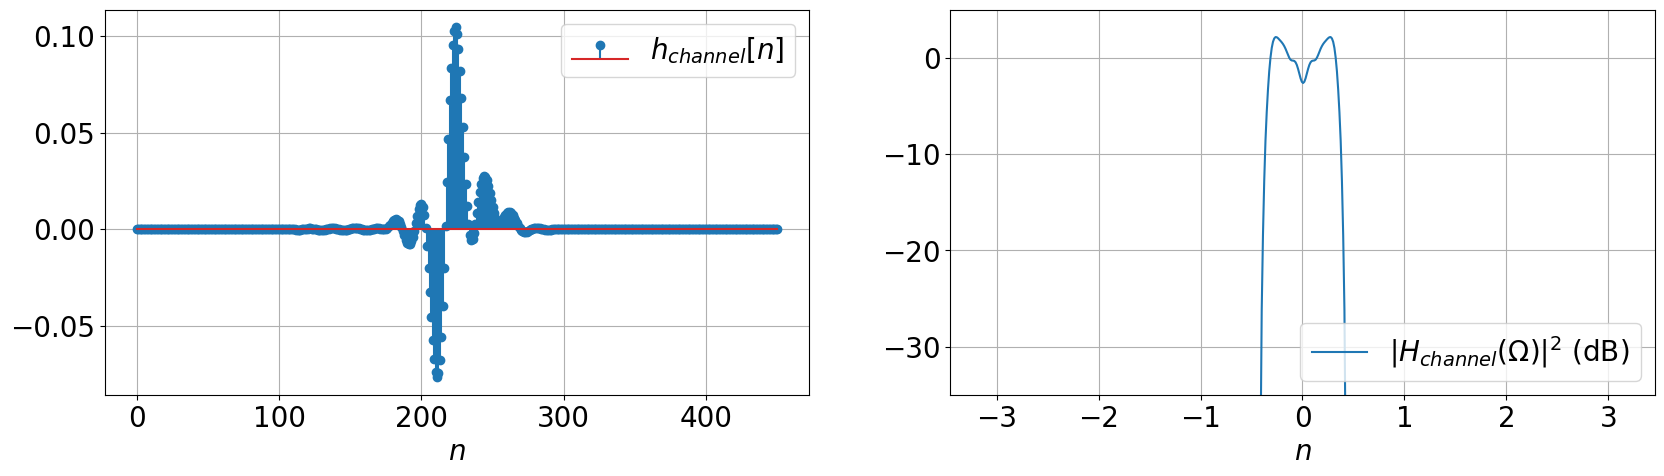

In [19]:
matplotlib.rc('figure', figsize=(20, 5) )

plt.figure()

plt.subplot(121)

# upper limit for number of symbols shown in the plot
plt.stem( h_up, label='$h_{channel}[n]$' )

#plt.ylim( (-2, 2 ) )
plt.grid(True)    
plt.legend(loc='upper right')    
plt.xlabel('$n$')


plt.subplot(122)

# upper limit for number of symbols shown in the plot
plt.plot( Omega, H_up_dB_shifted, label='$|H_{channel}(\Omega)|^2$ (dB)' )

plt.grid(True)    
plt.ylim( (-35, 5))
plt.legend(loc='lower right')    
plt.xlabel('$n$')



### Apply channel to pulse-shaped Tx signal and show result

In [20]:
# apply filtering due to channel on pulse-shaped sequence
r_rc = np.convolve( s_rc, h_up )


Text(0.5, 0, '$n$')

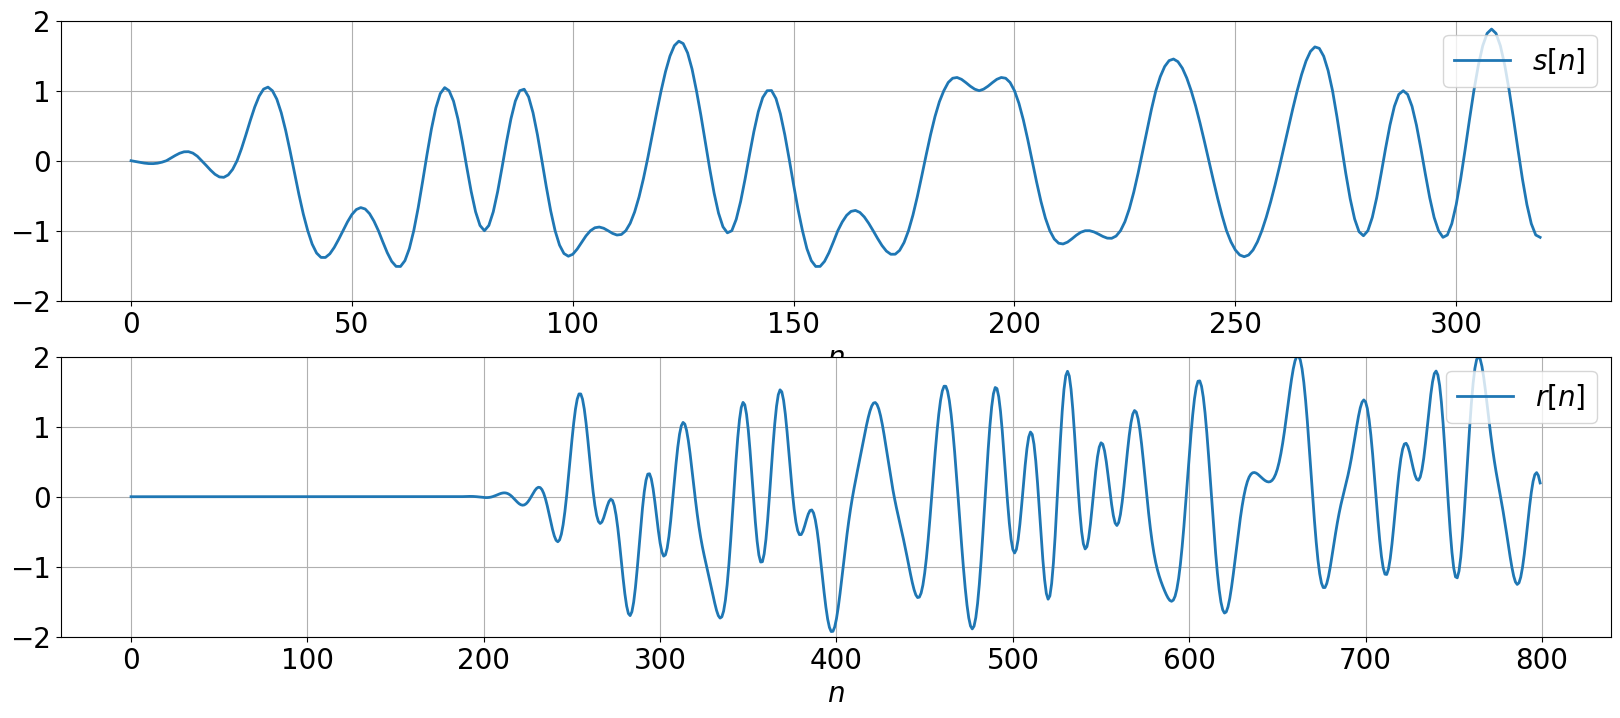

In [21]:
matplotlib.rc('figure', figsize=(20, 8) )

plt.figure()


plt.subplot(211)

# upper limit for number of symbols shown in the plot
ul = 40 * n_sps
plt.plot( np.arange( np.size( s_rc[ : ul ])) , s_rc[ : ul ], linewidth=2.0, label='$s[n]$' )

plt.ylim( (-2, 2 ) )
plt.grid(True)    
plt.legend(loc='upper right')    
plt.xlabel('$n$')


plt.subplot(212)

# upper limit for number of symbols shown in the plot
ul = 100 * n_sps
plt.plot( np.arange( np.size( r_rc[ : ul ])) , r_rc[ : ul ], linewidth=2.0, label='$r[n]$' )

plt.ylim( (-2, 2 ) )
plt.grid(True)    
plt.legend(loc='upper right')    
plt.xlabel('$n$')
